In [1]:
import numpy as np

In [2]:
import astropy.io.fits
import astropy.units as u

In [3]:
star_data = astropy.io.fits.open('../data/2M12504515+1133371.fits')

In [4]:
star_data[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =               104456 / length of dimension 1                          
NAXIS2  =                   52 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    5 / number of table fields                         
TTYPE1  = 'wavelength'                                                          
TFORM1  = '6144D   '                                                            
TDIM1   = '(6144)  '                                                            
TTYPE2  = 'flux    '                                                            
TFORM2  = '6144E   '        

In [5]:
flux, wave, ferr, mask = star_data[1].data['flux'], star_data[1].data['wavelength'] * u.Angstrom, star_data[1].data['flux_err'], star_data[1].data['mask']

In [6]:
import matplotlib.pyplot as plt

<h2> Create New Dataset </h2>
create this new ds and split into evaluation and test data.

In [7]:
import sys
sys.path.insert(0,'..')
from jabble.dataset import Dataset

In [8]:
all_data = Dataset.from_flux(wave,flux,ferr,mask)
all_data.set_mask(0.0,10.0)

../jabble/dataset.py:122: RuntimeWarning: divide by zero encountered in log
  ys = np.log(flux_interp/flux_norm)
../jabble/dataset.py:122: RuntimeWarning: invalid value encountered in log
  ys = np.log(flux_interp/flux_norm)
../jabble/dataset.py:123: RuntimeWarning: divide by zero encountered in true_divide
  yerr = ferr/flux_interp


In [9]:
import jabble.model
import astropy.coordinates as coord
import astropy.time as atime
import astropy.constants as const

In [10]:
times = atime.Time(star_data[1].data['BJD'], format='jd', scale='tdb')
location = coord.EarthLocation.of_site('APO')
target = coord.SkyCoord.from_name('2MASS J12504515+1133371',parse=True)
resolution = 33_500

In [11]:
bc = target.radial_velocity_correction(obstime=times,location=location).to(u.km/u.s)

In [12]:
def train_cycle(model,data,loss,indices,maxiter1,maxiter2):
    # Fitting Round 1
    print('fitting round 1')
    model.fix()
    model[1].fit()
    model[0].fix(indices)
    res1 = model.optimize(loss,data,maxiter1)
    model.fix()
    
    # Grid Search
    print('grid searching')
    vel_width = 5 * u.km/u.s
    vel_step = const.c/resolution/10.
    velocity_kern = np.arange(-vel_width.to(u.km/u.s).value,vel_width.to(u.km/u.s).value,vel_step.to(u.km/u.s).value)*u.km/u.s
    velocity_grid = np.add.outer(bc[indices],velocity_kern)
    
    shift_grid = jabble.dataset.shifts(velocity_grid)
    loss_array = model[0].grid_search(shift_grid,loss,model,data,indices)
    
    x_min, x_vals, y_vals, polynomials = jabble.dataset.get_parabolic_min(loss_array,shift_grid,return_all=True)     
    model[0].p[indices] = x_min
    
    # Fitting Round 2
    print('fitting round 2')
    model.fix()
    model[1].fit()
    model[0].fit(indices)
    res2 = model.optimize(loss,data,maxiter2)
    return model

In [13]:
def eval_cycle(model,data,loss,indices,maxiter):
    print('grid searching')
    vel_width = 5 * u.km/u.s
    vel_step = const.c/resolution/10.
    velocity_kern = np.arange(-vel_width.to(u.km/u.s).value,vel_width.to(u.km/u.s).value,vel_step.to(u.km/u.s).value)*u.km/u.s
    velocity_grid = np.add.outer(bc[indices],velocity_kern)
    
    shift_grid = jabble.dataset.shifts(velocity_grid)
    loss_array = model[0].grid_search(shift_grid,loss,model,data,indices)
    
    x_min, x_vals, y_vals, polynomials = jabble.dataset.get_parabolic_min(loss_array,shift_grid,return_all=True)     
    model[0].p[indices] = x_min
    
    # Fitting Round 2
    print('fitting round 2')
    model.fix()
    model[0].fit(indices)
    res2 = model.optimize(loss,data,maxiter)
    
    return model

In [14]:
def cross_validation(data,loss,train_cycle,eval_cycle):
    maxiter1 = 4
    maxiter2 = 4
    
    evaliter = 4
    
    velocities = np.zeros(data.ys.shape[0]) * u.m/u.s
    
    indices = list(range(data.ys.shape[0]))
    for i in indices:
        init_shifts = jabble.dataset.shifts(bc)
        vel_padding = 20 * u.km/u.s
        x_grid = jabble.model.create_x_grid(all_data.xs,vel_padding,4*resolution)
        model = jabble.model.stellar_model(init_shifts,x_grid)
        
        train_ind = indices.copy()
        train_ind.remove(i)
        eval_ind = [i]
        
        train_data = data[train_ind]
        eval_data = data[eval_ind]
        
        model = train_cycle(model,train_data,loss,train_ind,maxiter1,maxiter2)
        model = eval_cycle(model,eval_data,loss,eval_ind,evaliter)
        
#         print(jabble.dataset.velocities(model[0].p[i]).unit,velocities.unit)
        velocities[i] = jabble.dataset.velocities(model[0].p[i])
    return velocities

In [16]:
import jabble.loss

In [17]:
loss = jabble.loss.ChiSquare()

In [18]:
velocities = cross_validation(all_data,loss,train_cycle,eval_cycle)

fitting round 1
grid searching
epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 2
epch 3: min 2
epch 4: min 0
minimum likely out of range
epch 5: min 5
epch 6: min 5
epch 7: min 5
epch 8: min 0
minimum likely out of range
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 11
minimum likely out of range
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 6
epch 22: min 5
epch 23: min 5
epch 24: min 6
epch 25: min 6
epch 26: min 5
epch 27: min 6
epch 28: min 6
epch 29: min 11
minimum likely out of range
epch 30: min 10
epch 31: min 10
epch 32: min 11
minimum likely out of range
epch 33: min 11
minimum likely out of range
epch 34: min 11
minimum likely out o

grid searching
epch 0: min 0
minimum likely out of range
fitting round 2
fitting round 1
grid searching
epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 0
minimum likely out of range
epch 9: min 1
epch 10: min 5
epch 11: min 5
epch 12: min 1
epch 13: min 11
minimum likely out of range
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 6
epch 22: min 5
epch 23: min 5
epch 24: min 6
epch 25: min 6
epch 26: min 5
epch 27: min 5
epch 28: min 6
epch 29: min 11
minimum likely out of range

epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 2
epch 8: min 2
epch 9: min 5
epch 10: min 5
epch 11: min 3
epch 12: min 5
epch 13: min 11
minimum likely out of range
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 6
epch 22: min 5
epch 23: min 5
epch 24: min 6
epch 25: min 6
epch 26: min 5
epch 27: min 5
epch 28: min 6
epch 29: min 11
minimum likely out of range
epch 30: min 10
epch 31: min 10
epch 32: min 11
minimum likely out of range
epch 33: min 11
minimum likely out of range
epch 34: min 11
minimum likely out of r

grid searching
epch 0: min 11
minimum likely out of range
fitting round 2
fitting round 1
grid searching
epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 1
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 6
epch 7: min 4
epch 8: min 5
epch 9: min 6
epch 10: min 6
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 10
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 9
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 10
epch 21: min 6
epch 22: min 5
epch 23: min 5
epch 24: min 6
epch 25: min 6
epch 26: min 5
epch 27: min 6
epch 28: min 6
epch 29: min 11
minimum likely out of range
epch 30: min 10
epch 31: min 10
epch 32: min 11
minimum likely out of range
epch 33: min 11
minimum likely out of range
epch 34: min 11
minimum likely out of range
epch 35: min 11
minimum likely o

grid searching
epch 0: min 6
fitting round 2
fitting round 1
grid searching
epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 5
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 5
epch 24: min 6
epch 25: min 6
epch 26: min 5
epch 27: min 5
epch 28: min 6
epch 29: min 11
minimum likely out of range
epch 30: min 11
minimum likely out of range
epch 31: mi

grid searching
epch 0: min 9
fitting round 2
fitting round 1
grid searching
epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 5
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 5
epch 24: min 5
epch 25: min 6
epch 26: min 6
epch 27: min 5
epch 28: min 6
epch 29: min 11
minimum likely out of range
epch 30: min 11
minimum likely out of range
epch 31: mi

grid searching
epch 0: min 11
minimum likely out of range
fitting round 2
fitting round 1
grid searching
epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 5
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 5
epch 24: min 5
epch 25: min 6
epch 26: min 6
epch 27: min 5
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: mi

grid searching
epch 0: min 0
minimum likely out of range
fitting round 2
fitting round 1
grid searching
epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 0
minimum likely out of range
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 5
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 5
epch 24: min 5
epch 25: min 6
epch 26: min 6
epch 27: min 5
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum like

epch 0: min 1
fitting round 2
fitting round 1
grid searching
epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 0
minimum likely out of range
epch 10: min 0
minimum likely out of range
epch 11: min 5
epch 12: min 5
epch 13: min 0
minimum likely out of range
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 5
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11

grid searching
epch 0: min 1
fitting round 2
fitting round 1
grid searching
epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 5
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 5
epch 24: min 5
epch 25: min 6
epch 26: min 6
epch 27: min 5
epch 28: min 5
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 11
minimum likely out of ra

In [19]:
x = np.arange(0,5)
x[True]

array([[0, 1, 2, 3, 4]])

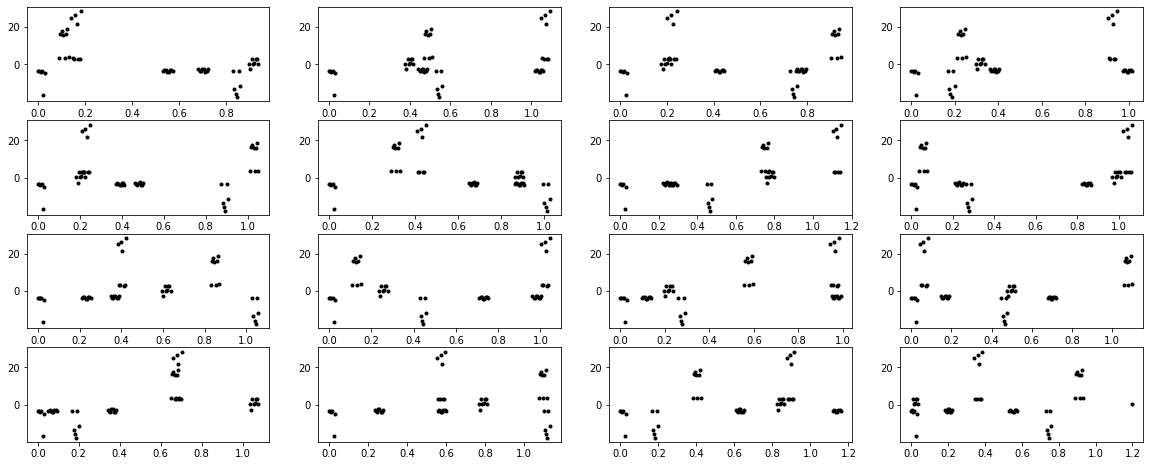

In [27]:
# period = 1.2 * u.day
periods = np.linspace(1.1,1.2,16) * u.day
fig, axes = plt.subplots(4,4,figsize=(20,8))
for i,period in enumerate(periods):
    axes[i % 4][i // 4].plot(((times - min(times)).to(u.day).value) % period.to(u.day).value,(velocities - bc).to(u.km/u.s).value,'.k')
plt.show()